In [1]:
# ---------------------------
# Data Manipulation Libraries
# ---------------------------
import pandas as pd        # Handle tabular data (DataFrames), CSV/Excel I/O
import numpy as np         # Numerical operations, arrays, linear algebra

# ---------------------------
# Data Visualization Libraries
# ---------------------------
import matplotlib.pyplot as plt   # Core plotting library
import seaborn as sns             # High-level statistical visualization

# ---------------------------
# Utilities & System Helpers
# ---------------------------
import warnings               # Manage warning messages
from datetime import datetime # Work with dates and timestamps

# ---------------------------
# Machine Learning for Imputation
# ---------------------------
from sklearn.ensemble import GradientBoostingRegressor
# Gradient boosting model, can be used to predict missing values in datasets

# ---------------------------
# Time Series Analysis Tools
# ---------------------------
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose time series into trend, seasonal, and residual components
from statsmodels.graphics.tsaplots import plot_acf
# Plot autocorrelation function to understand time series patterns


# Importing data and cleaning

In [2]:
warnings.filterwarnings(
    "ignore",
    message="Conditional Formatting extension is not supported"
)

df = pd.read_excel("SRP_Electricity_Demand.xlsx", sheet_name='Known Data Issues')

# Select relevant columns
df = df[["Local date", "Hour", "Local time", "Adjusted D", "Adjusted NG", "DF", "Adjusted TI"]]

df = df.rename(columns={'Adjusted D': 'Demand (MWh)', 'Adjusted NG': 'Net Generation (MWh)', 'Adjusted TI': 'Total Interchange (MWh)', 'DF':'Demand Forecast (MWh)'})

# Convert to datetime and set index
df["Local time"] = pd.to_datetime(df["Local time"])
df = df.set_index("Local time")

# Filter rows up to 2025-10-31
df = df[(df.index >= "2015-01-01") & (df.index <= "2025-10-31 23:00:00")]

df

,Local date,Hour,Demand (MWh),Net Generation (MWh),Demand Forecast (MWh),Total Interchange (MWh)
Local time,,,,,,
2015-07-01 01:00:00,2015-07-01,1,4103.0,4974.0,3920.0,871.0
2015-07-01 02:00:00,2015-07-01,2,3897.0,4422.0,3693.0,525.0
2015-07-01 03:00:00,2015-07-01,3,3694.0,4094.0,3610.0,400.0
2015-07-01 04:00:00,2015-07-01,4,3590.0,3865.0,3505.0,275.0
2015-07-01 05:00:00,2015-07-01,5,3546.0,3739.0,3509.0,193.0
...,...,...,...,...,...,...
2025-10-31 19:00:00,2025-10-31,19,4213.0,5934.0,4239.0,1720.0
2025-10-31 20:00:00,2025-10-31,20,3906.0,5694.0,4054.0,1788.0
2025-10-31 21:00:00,2025-10-31,21,3747.0,5503.0,3945.0,1755.0


In [3]:
#df["Local time"] = pd.to_datetime(df["Local time"])

# There are missing values and we need to impute them:

In [4]:
for col in ['Demand (MWh)', 'Demand Forecast (MWh)', 'Net Generation (MWh)']:
    df[col] = df[col].mask(df[col] < 10, np.nan)

# Optional: check how many NaNs were created
for col in ['Demand (MWh)', 'Demand Forecast (MWh)', 'Net Generation (MWh)']:
    print(f"{col}: {df[col].isna().sum()} missing values")



Demand (MWh): 673 missing values
Demand Forecast (MWh): 5975 missing values
Net Generation (MWh): 697 missing values


<Axes: xlabel='Local time'>

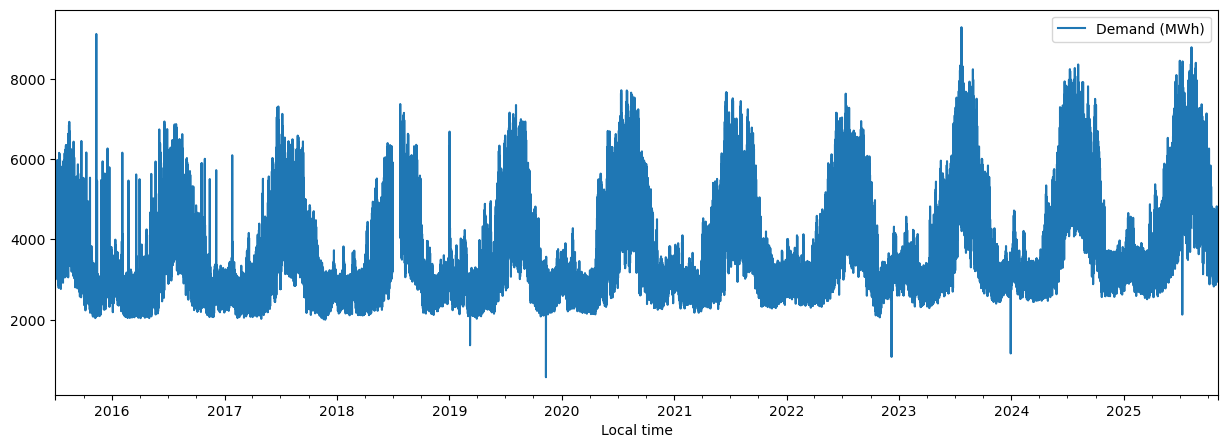

In [5]:
df.plot(y='Demand (MWh)', figsize= (15,5))

In [6]:
# Check how many null values
(df.isnull().sum().sort_values(ascending=False))

Demand Forecast (MWh)      5975
Total Interchange (MWh)     964
Net Generation (MWh)        697
Demand (MWh)                673
Hour                          0
Local date                    0
dtype: int64

In [7]:
((df.isnull().sum()/len(df))*100).sort_values(ascending=False)

Demand Forecast (MWh)      6.593249
Total Interchange (MWh)    1.063748
Net Generation (MWh)       0.769120
Demand (MWh)               0.742637
Hour                       0.000000
Local date                 0.000000
dtype: float64

# Filling null values using ML


--- Processing column: Net Generation (MWh) ---


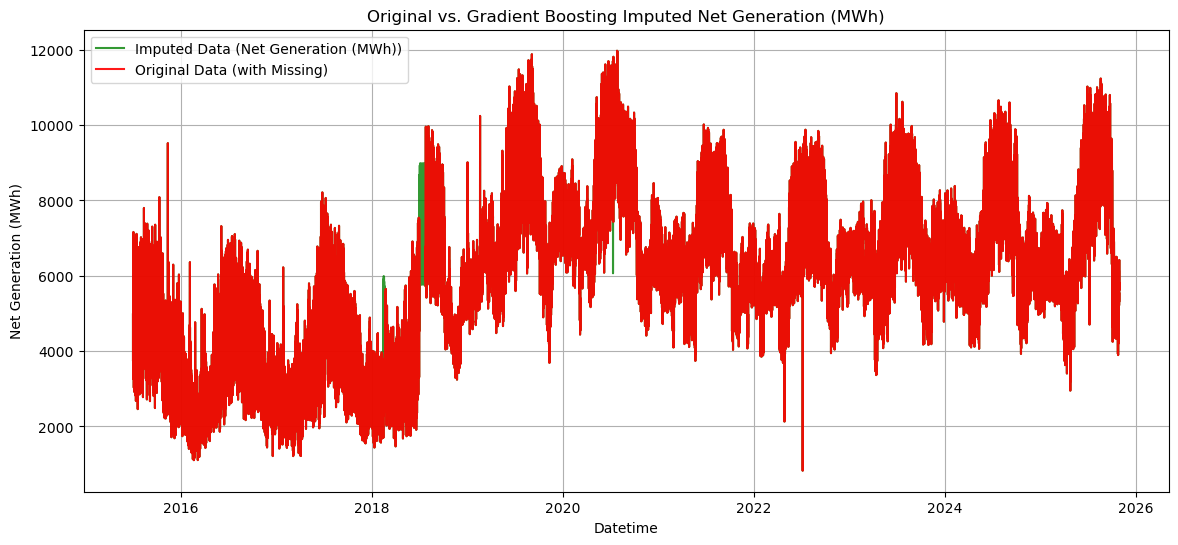

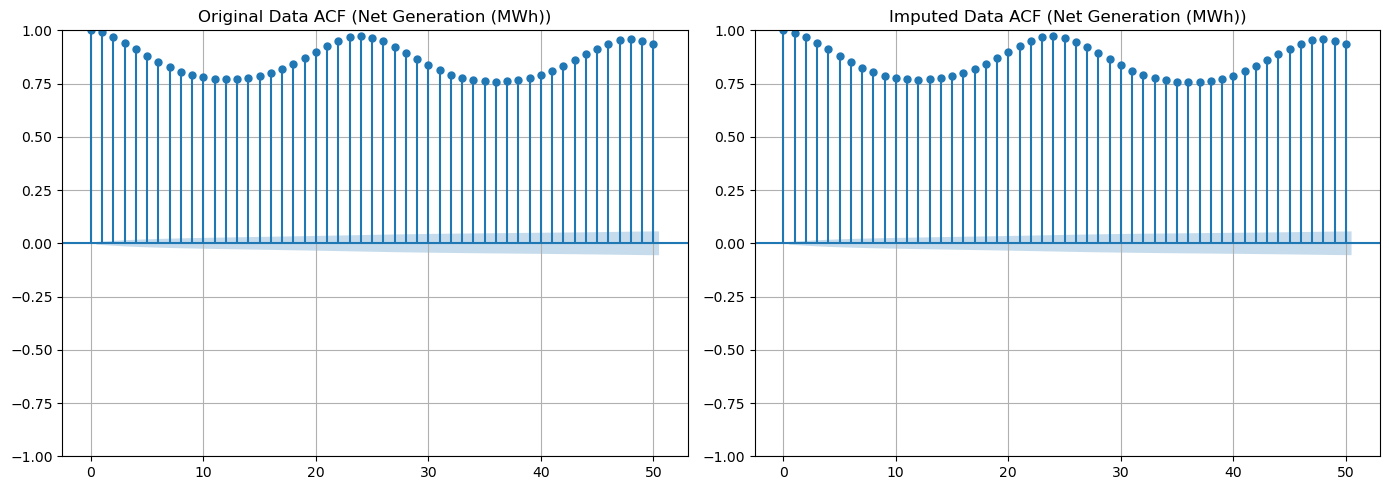

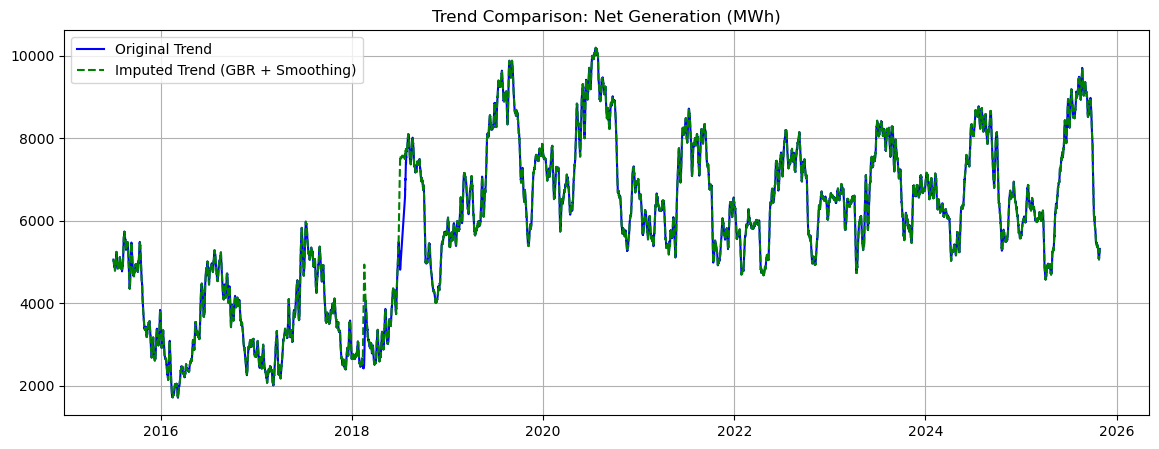

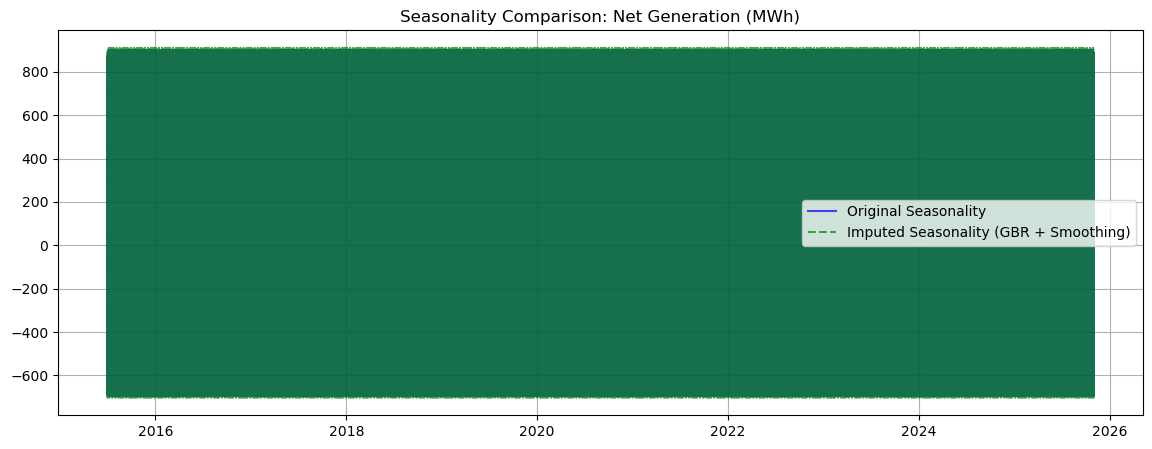


--- Processing column: Total Interchange (MWh) ---


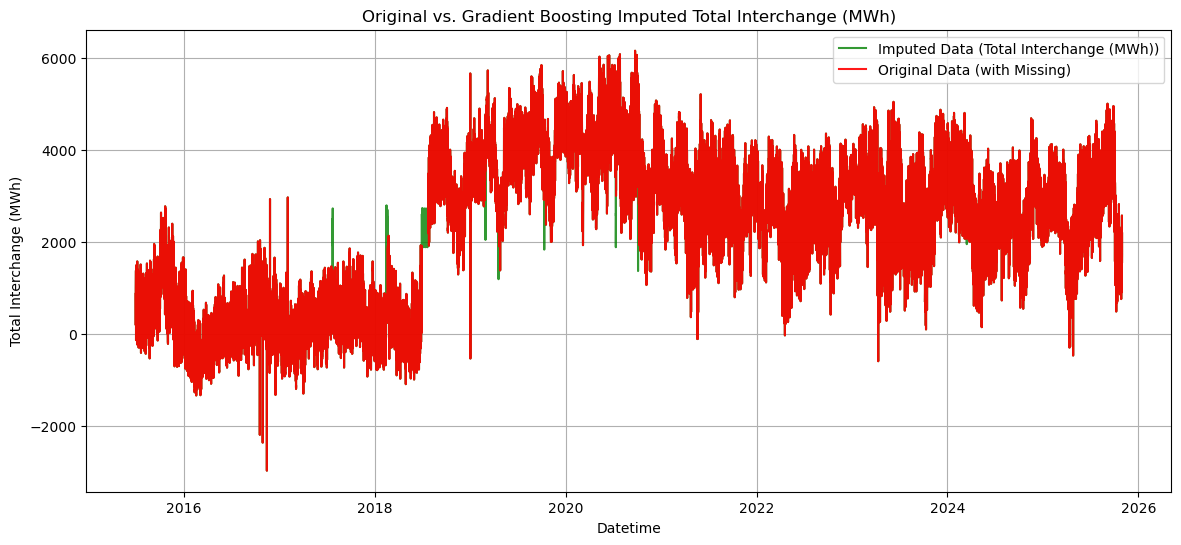

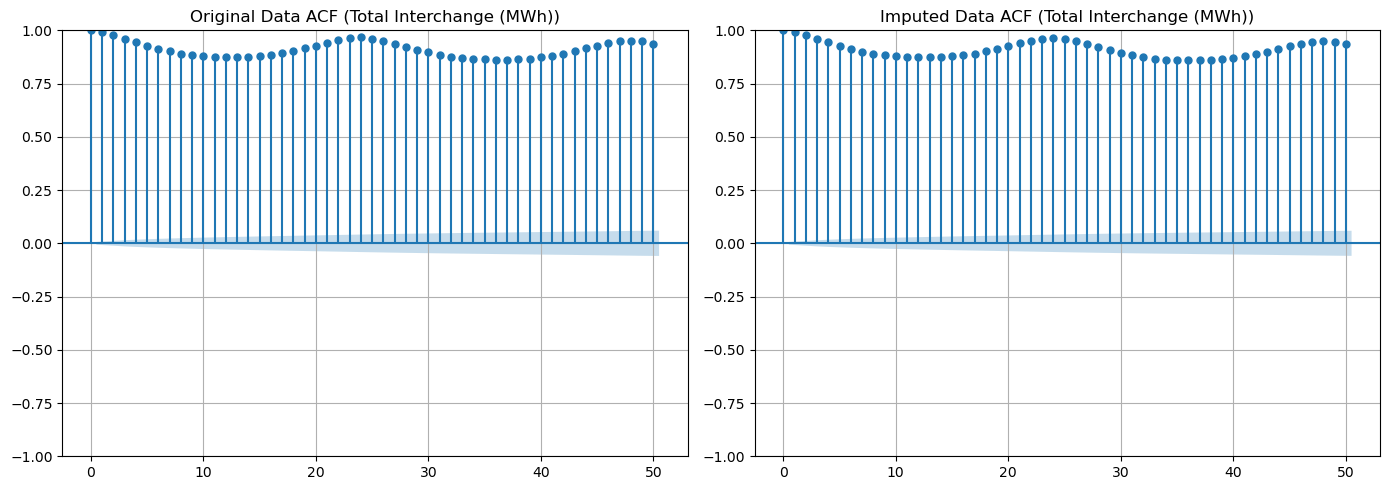

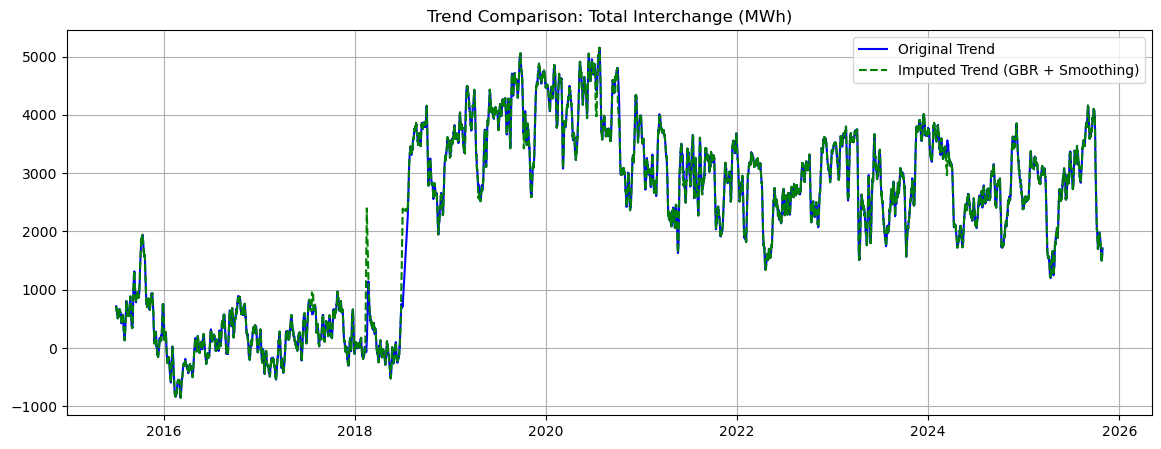

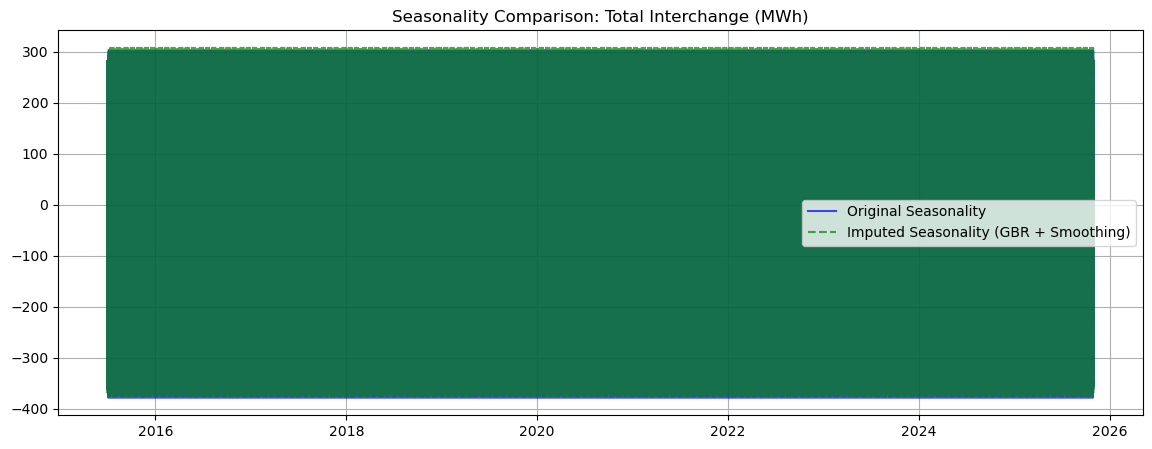


--- Processing column: Demand Forecast (MWh) ---


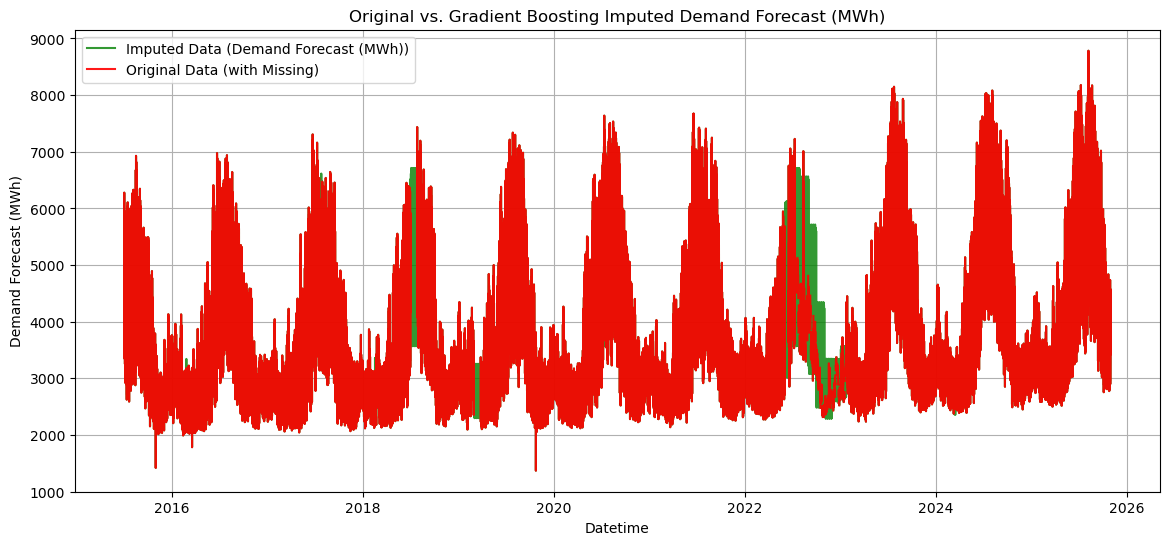

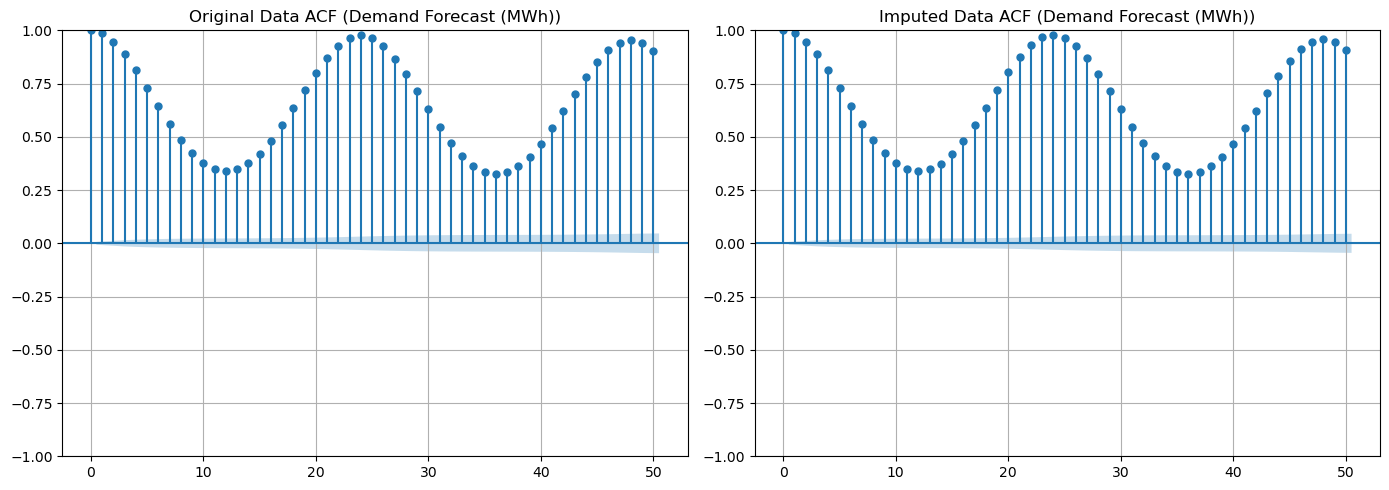

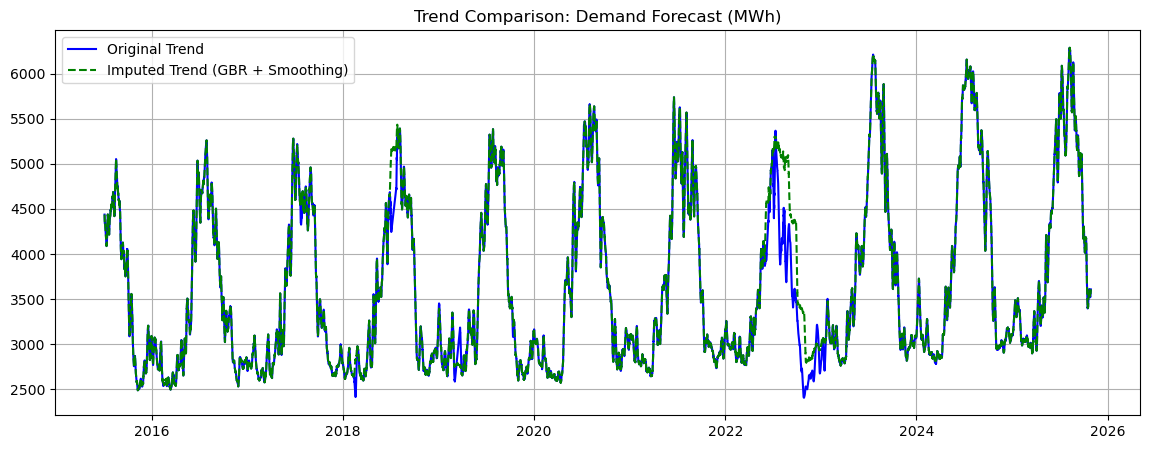

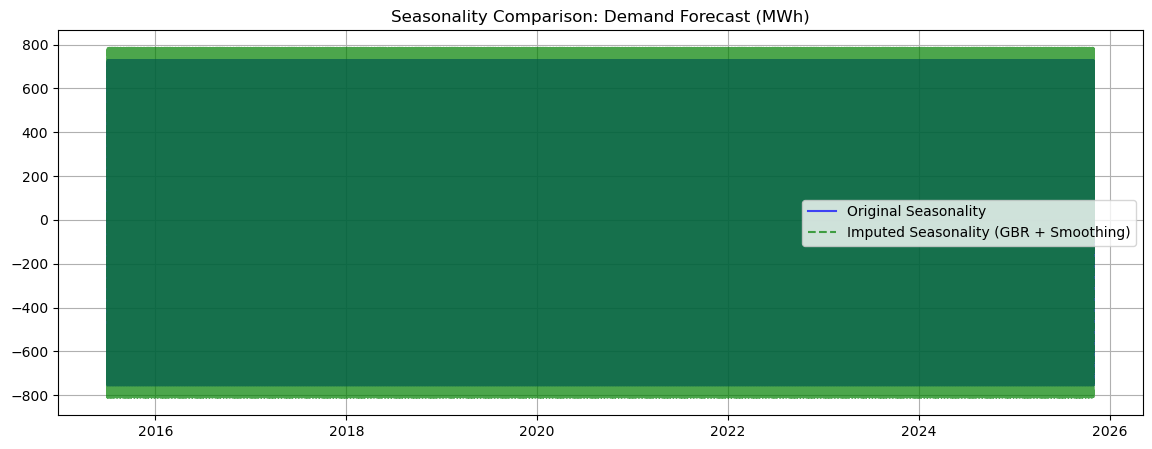


--- Processing column: Demand (MWh) ---


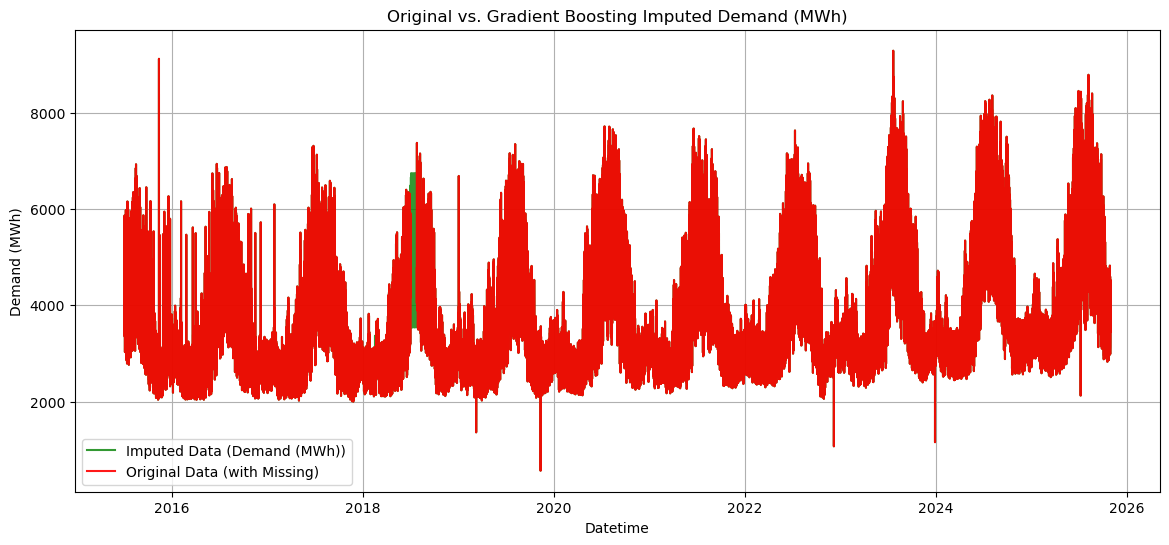

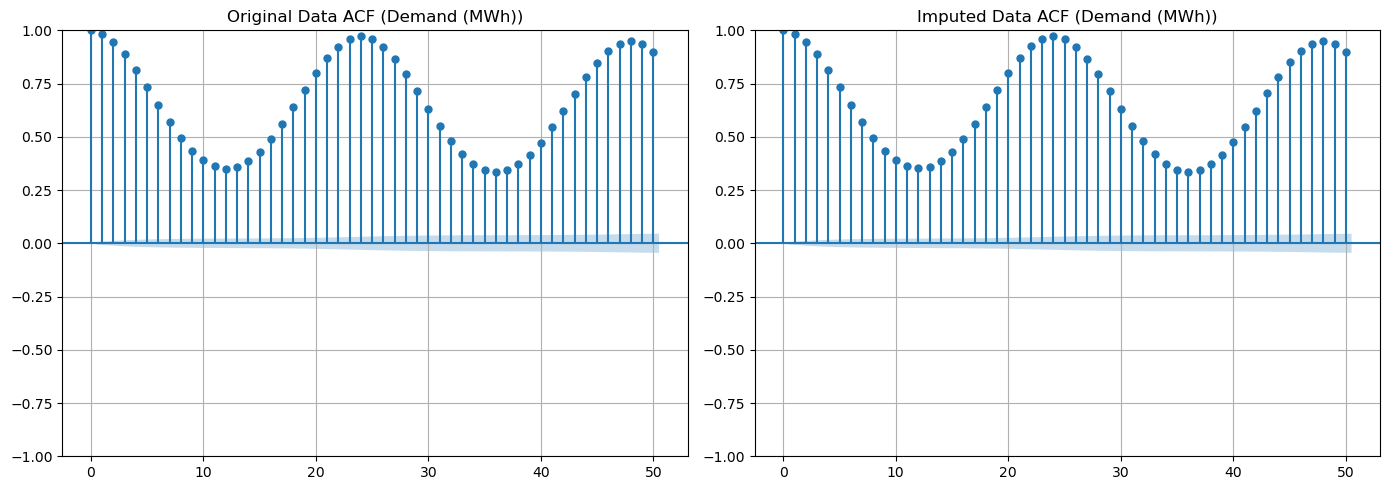

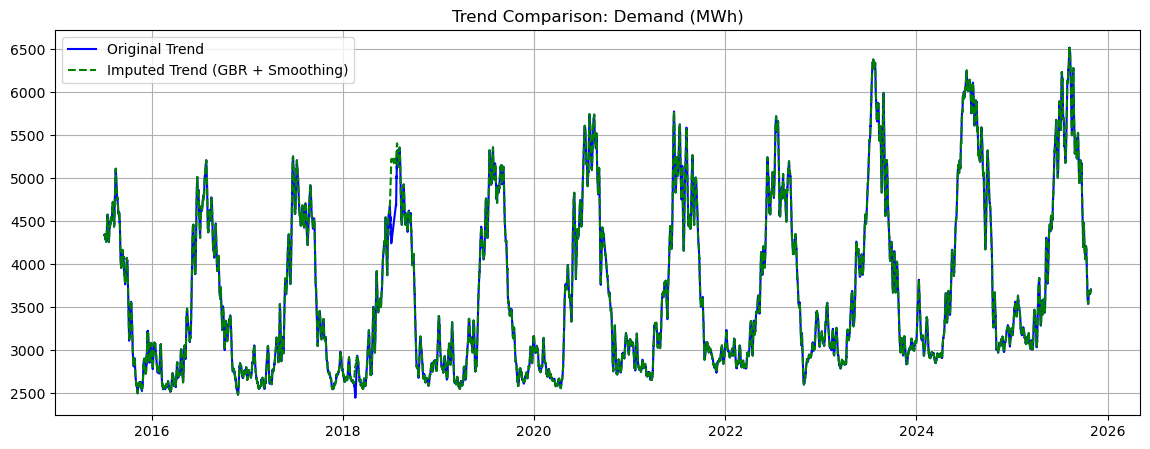

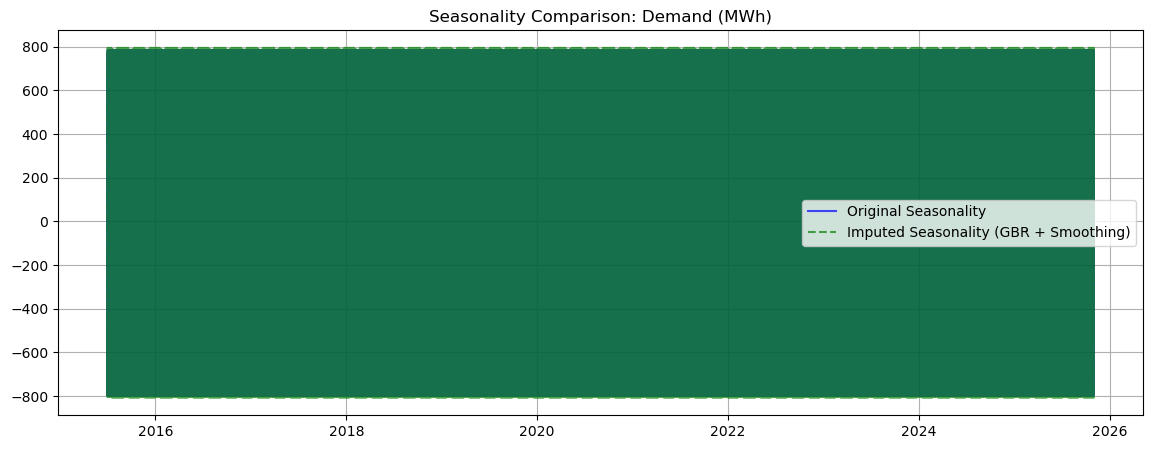

In [8]:
df.reset_index(inplace=True)

# List of target columns to process
target_columns = [
    'Net Generation (MWh)',
    'Total Interchange (MWh)',
    'Demand Forecast (MWh)',
    'Demand (MWh)'
]

# Time range for plotting example month
start_month = pd.to_datetime('2015-01-01')
end_month = pd.to_datetime('2025-10-31')

# Make a single copy to update progressively
filled_data = df.copy()

for target_col in target_columns:
    print(f"\n--- Processing column: {target_col} ---")
    
    # ---------------------------
    # 1. Separate non-missing and missing data
    # ---------------------------
    non_missing_data = filled_data.dropna(subset=[target_col]).copy()
    missing_data = filled_data[filled_data[target_col].isna()].copy()

    if missing_data.empty:
        print(f"No missing values for {target_col}, skipping GBR.")
        continue

    # ---------------------------
    # 2. Extract time-based features
    # ---------------------------
    for dataset in [non_missing_data, missing_data]:
        dataset['hour'] = dataset['Local time'].dt.hour
        dataset['dayofweek'] = dataset['Local time'].dt.dayofweek
        dataset['month'] = dataset['Local time'].dt.month

    # ---------------------------
    # 3. Train Gradient Boosting Regressor
    # ---------------------------
    features = ['hour', 'dayofweek', 'month']
    X_train = non_missing_data[features]
    y_train = non_missing_data[target_col]
    X_missing = missing_data[features]

    gb_regressor = GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    )
    gb_regressor.fit(X_train, y_train)

    # ---------------------------
    # 4. Predict missing values and fill in-place
    # ---------------------------
    predicted_values = gb_regressor.predict(X_missing)
    filled_data.loc[missing_data.index, target_col] = predicted_values

    # ---------------------------
    # 5. Time-based interpolation
    # ---------------------------
    filled_data = filled_data.set_index('Local time')
    filled_data[target_col] = filled_data[target_col].interpolate(method='time')
    filled_data = filled_data.reset_index()

    # ---------------------------
    # 6. STL Decomposition
    # ---------------------------
    original_series = df.set_index('Local time')[target_col]
    original_decompose = seasonal_decompose(original_series.interpolate(), model='additive', period=144)

    imputed_series = filled_data.set_index('Local time')[target_col]
    imputed_decompose = seasonal_decompose(imputed_series, model='additive', period=144)

    # ---------------------------
    # 7. Plot example month
    # ---------------------------
    plot_data = filled_data[(filled_data['Local time'] >= start_month) &
                            (filled_data['Local time'] <= end_month)]
    original_month_data = df[(df['Local time'] >= start_month) &
                             (df['Local time'] <= end_month)]

    plt.figure(figsize=(14, 6))
    plt.plot(plot_data['Local time'], plot_data[target_col], label=f'Imputed Data ({target_col})', color='green', alpha=0.8)
    plt.plot(original_month_data['Local time'], original_month_data[target_col], label='Original Data (with Missing)', color='red', alpha=0.9)
    plt.title(f'Original vs. Gradient Boosting Imputed {target_col}')
    plt.xlabel('Datetime')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------------------------
    # 8. Autocorrelation comparison
    # ---------------------------
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plot_acf(df[target_col].dropna(), lags=50, ax=plt.gca(), title=f'Original Data ACF ({target_col})')
    plt.grid(True)
    plt.subplot(1,2,2)
    plot_acf(filled_data[target_col], lags=50, ax=plt.gca(), title=f'Imputed Data ACF ({target_col})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # 9. STL Decomposition plots
    # ---------------------------
    plt.figure(figsize=(14,5))
    plt.plot(original_decompose.trend, label='Original Trend', color='blue')
    plt.plot(imputed_decompose.trend, label='Imputed Trend (GBR + Smoothing)', color='green', linestyle='--')
    plt.title(f'Trend Comparison: {target_col}')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14,5))
    plt.plot(original_decompose.seasonal, label='Original Seasonality', color='blue', alpha=0.7)
    plt.plot(imputed_decompose.seasonal, label='Imputed Seasonality (GBR + Smoothing)', color='green', linestyle='--', alpha=0.7)
    plt.title(f'Seasonality Comparison: {target_col}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
# Check how many null values
(filled_data.isnull().sum().sort_values(ascending=False))

Local time                 0
Local date                 0
Hour                       0
Demand (MWh)               0
Net Generation (MWh)       0
Demand Forecast (MWh)      0
Total Interchange (MWh)    0
dtype: int64

# Import weather data and clean

In [10]:
Phoenix_Weather_Data_2015_2025 = pd.read_csv("Phoenix_Weather_Data_2015_2025.csv")
Phoenix_Weather_Data_2015_2025['Local time'] = (
    pd.to_datetime(Phoenix_Weather_Data_2015_2025['Year'].astype(str), format='%Y')
    + pd.to_timedelta(Phoenix_Weather_Data_2015_2025['Day of Year'] - 1, unit='D')
    + pd.to_timedelta(Phoenix_Weather_Data_2015_2025['Hour of Day'] - 1, unit='h')
)
Phoenix_Weather_Data_2015_2025['Temperature (F)'] = (Phoenix_Weather_Data_2015_2025['Air Temperature'] * 9/5) + 32
Phoenix_Weather_Data_2015_2025['Temperature (F)'] = Phoenix_Weather_Data_2015_2025['Temperature (F)'].round(decimals=0).astype(int)
Phoenix_Weather_Data_2015_2025 = Phoenix_Weather_Data_2015_2025[["Year", "Hour of Day", "Temperature (F)", "Local time"]]
Phoenix_Weather_Data_2015_2025 = Phoenix_Weather_Data_2015_2025.rename(columns={'Hour of Day': 'Hour'})
Phoenix_Weather_Data_2015_2025

,Year,Hour,Temperature (F),Local time
0,2025,1,45,2025-01-01 00:00:00
1,2025,2,45,2025-01-01 01:00:00
2,2025,3,43,2025-01-01 02:00:00
3,2025,4,42,2025-01-01 03:00:00
4,2025,5,42,2025-01-01 04:00:00
...,...,...,...,...
95131,2015,20,49,2015-12-31 19:00:00
95132,2015,21,45,2015-12-31 20:00:00
95133,2015,22,46,2015-12-31 21:00:00
95134,2015,23,40,2015-12-31 22:00:00


In [11]:
# Check how many null values
(Phoenix_Weather_Data_2015_2025.isnull().sum().sort_values(ascending=False))

Year               0
Hour               0
Temperature (F)    0
Local time         0
dtype: int64

# Merge the datasets

In [12]:
merged_df = pd.merge(Phoenix_Weather_Data_2015_2025, filled_data, on='Local time')
merged_df

,Year,Hour_x,Temperature (F),Local time,Local date,Hour_y,Demand (MWh),Net Generation (MWh),Demand Forecast (MWh),Total Interchange (MWh)
0,2025,1,45,2025-01-01 00:00:00,2024-12-31,24,3050.0,5560.0,3030.0,2510.0
1,2025,2,45,2025-01-01 01:00:00,2025-01-01,1,3017.0,5362.0,2917.0,2345.0
2,2025,3,43,2025-01-01 02:00:00,2025-01-01,2,2946.0,5308.0,2872.0,2362.0
3,2025,4,42,2025-01-01 03:00:00,2025-01-01,3,2913.0,5324.0,2892.0,2411.0
4,2025,5,42,2025-01-01 04:00:00,2025-01-01,4,2920.0,5311.0,2918.0,2391.0
...,...,...,...,...,...,...,...,...,...,...
90642,2015,20,49,2015-12-31 19:00:00,2015-12-31,19,3262.0,4671.0,3330.0,1409.0
90643,2015,21,45,2015-12-31 20:00:00,2015-12-31,20,3220.0,4547.0,3427.0,1327.0
90644,2015,22,46,2015-12-31 21:00:00,2015-12-31,21,3142.0,4520.0,3434.0,1378.0
90645,2015,23,40,2015-12-31 22:00:00,2015-12-31,22,3098.0,4378.0,3429.0,1280.0


In [13]:
merged_df.set_index('Local time', inplace=True)
merged_df.sort_index(ascending=False, inplace=True)

In [14]:
(merged_df.isnull().sum().sort_values(ascending=False))

Year                       0
Hour_x                     0
Temperature (F)            0
Local date                 0
Hour_y                     0
Demand (MWh)               0
Net Generation (MWh)       0
Demand Forecast (MWh)      0
Total Interchange (MWh)    0
dtype: int64

In [15]:
merged_df

,Year,Hour_x,Temperature (F),Local date,Hour_y,Demand (MWh),Net Generation (MWh),Demand Forecast (MWh),Total Interchange (MWh)
Local time,,,,,,,,,
2025-10-31 23:00:00,2025,24,61,2025-10-31,23,3496.0,5910.0,3589.0,2413.0
2025-10-31 22:00:00,2025,23,63,2025-10-31,22,3671.0,5651.0,3785.0,1980.0
2025-10-31 21:00:00,2025,22,64,2025-10-31,21,3747.0,5503.0,3945.0,1755.0
2025-10-31 20:00:00,2025,21,64,2025-10-31,20,3906.0,5694.0,4054.0,1788.0
2025-10-31 19:00:00,2025,20,68,2025-10-31,19,4213.0,5934.0,4239.0,1720.0
...,...,...,...,...,...,...,...,...,...
2015-07-01 05:00:00,2015,6,82,2015-07-01,5,3546.0,3739.0,3509.0,193.0
2015-07-01 04:00:00,2015,5,83,2015-07-01,4,3590.0,3865.0,3505.0,275.0
2015-07-01 03:00:00,2015,4,85,2015-07-01,3,3694.0,4094.0,3610.0,400.0


In [16]:
merged_df = merged_df[['Temperature (F)', 'Demand (MWh)', 'Net Generation (MWh)', 'Demand Forecast (MWh)', 'Total Interchange (MWh)']]
merged_df

,Temperature (F),Demand (MWh),Net Generation (MWh),Demand Forecast (MWh),Total Interchange (MWh)
Local time,,,,,
2025-10-31 23:00:00,61,3496.0,5910.0,3589.0,2413.0
2025-10-31 22:00:00,63,3671.0,5651.0,3785.0,1980.0
2025-10-31 21:00:00,64,3747.0,5503.0,3945.0,1755.0
2025-10-31 20:00:00,64,3906.0,5694.0,4054.0,1788.0
2025-10-31 19:00:00,68,4213.0,5934.0,4239.0,1720.0
...,...,...,...,...,...
2015-07-01 05:00:00,82,3546.0,3739.0,3509.0,193.0
2015-07-01 04:00:00,83,3590.0,3865.0,3505.0,275.0
2015-07-01 03:00:00,85,3694.0,4094.0,3610.0,400.0


In [17]:
# I commented it out because the saved dataset is in the cleaned folder
# merged_df.to_csv("demand_df.csv")